In [6]:
%matplotlib inline

In [7]:
# %% [markdown]
# Extended Dataset Quality Checks

# This notebook performs several checks on the generated license plate dataset beyond 
# just the angle distribution. It assumes the dataset (images and metadata JSON files) has 
# already been generated by `lp_processing.py`.

# **Checks Included:**
# 1.  **License Plate Digit Distribution:** Analyzes the frequency of digits 0-9.
# 2.  **Bounding Box Visualization:** Overlays digit bounding boxes on distorted images.
# 3.  **Visual Inspection (Original vs. Distorted):** Compares original and processed images.


# %%
import os
import glob
import json
import random
import cv2  # OpenCV for image loading and drawing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# ## 0. Setup and Load Metadata
# Define the dataset directory and load all metadata into a DataFrame.

# ----- USER CONFIGURATION -----
# Directory containing the dataset (images and metadata JSON files)
DATASET_DIR = "data/train" 
# How many random samples to show for visual checks
NUM_VISUAL_SAMPLES = 1
# Define the expected output size (width, height) if downscaling was used in generation.
# Set to None if no downscaling was applied 
# Example: EXPECTED_OUTPUT_SIZE = (256, 64) # for out_scale = 1
EXPECTED_OUTPUT_SIZE = (256, 64) 
# -----------------------------

METADATA_PATTERN = os.path.join(DATASET_DIR, "metadata_*.json")

print(f"--- Loading Metadata from: {DATASET_DIR} ---")

# Check if the directory exists
if not os.path.isdir(DATASET_DIR):
    print(f"Error: Directory not found: {DATASET_DIR}")
    metadata_files = []
    df = pd.DataFrame()
else:
    metadata_files = glob.glob(METADATA_PATTERN)
    if not metadata_files:
        print(f"Warning: No metadata files found matching '{METADATA_PATTERN}'.")
    print(f"Found {len(metadata_files)} metadata files.")

    # Load metadata
    data = []
    required_keys = {'idx', 'plate_number', 'alpha', 'beta', 'digit_bboxes'}
    for f_path in metadata_files:
        try:
            with open(f_path, 'r') as f:
                metadata = json.load(f)
                # Basic check for essential keys
                if required_keys.issubset(metadata.keys()):
                     # Add file path for later image loading
                    metadata['metadata_path'] = f_path
                    metadata['image_index'] = metadata['idx'] # Use 'idx' as the identifier
                    data.append(metadata)
                else:
                    missing_keys = required_keys - set(metadata.keys())
                    print(f"Warning: Missing keys {missing_keys} in {os.path.basename(f_path)}. Skipping.")
        except json.JSONDecodeError:
            print(f"Warning: Could not decode JSON from {os.path.basename(f_path)}. Skipping.")
        except Exception as e:
            print(f"Warning: Error processing {os.path.basename(f_path)}: {e}. Skipping.")

    if data:
        df = pd.DataFrame(data)
        print(f"\nSuccessfully loaded metadata for {len(df)} samples.")
        # Optional: Display sample data
        # print("\nSample of loaded data:")
        # print(df[['image_index', 'plate_number', 'alpha', 'beta']].head())
    else:
        df = pd.DataFrame() # Create empty dataframe if no data loaded
        print("\nNo valid metadata loaded. Cannot proceed with checks.")


# %%
import pandas as pd
import numpy as np # Import numpy for range generation and rounding
import matplotlib.pyplot as plt
import seaborn as sns
import os # For os.path.basename
from matplotlib.ticker import FixedLocator, FuncFormatter # For better tick control

# ## 1.  License Plate Digit Distribution
# Checks if the digits 0-9 appear with roughly equal frequency in the generated plate numbers.

# %%
if not df.empty:
    print(f"\n--- Check 1: Digit Distribution ---")
    all_plate_numbers = "".join(df['plate_number'].tolist())
    digit_counts = Counter(all_plate_numbers)
    # Ensure all digits 0-9 are present in the counts, even if zero
    full_digit_counts = {str(i): digit_counts.get(str(i), 0) for i in range(10)}

    if not all_plate_numbers:
         print("No plate numbers found in metadata.")
    else:
        print(f"Total digits analyzed: {len(all_plate_numbers)}")

        # --- MODIFICATION START ---
        # Prepare data for seaborn plot in a preferred format
        # Convert keys (digits '0'-'9') and values (counts) for plotting
        plot_digits = sorted(full_digit_counts.keys()) # Ensure consistent order '0' through '9'
        plot_counts = [full_digit_counts[d] for d in plot_digits]
        # --- MODIFICATION END ---


        # Create bar plot using the prepared lists/arrays
        plt.figure(figsize=(8, 4))
        # Pass the prepared lists directly
        sns.barplot(x=plot_digits, y=plot_counts)
        plt.title(f'Frequency of Digits (0-9) in Plate Numbers\n(Dataset: {os.path.basename(DATASET_DIR)})')
        plt.xlabel('Digit')
        plt.ylabel('Frequency Count')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
else:
    print("Skipping Check 1: Metadata DataFrame is empty.")

# ## 2. Bounding Box Visualization
# Randomly selects a few samples and draws the digit bounding boxes (`digit_bboxes`) onto the *distorted* image to verify their accuracy after processing.

# %%
if not df.empty:
    print(f"\n--- Check 2: Bounding Box Visualization ({NUM_VISUAL_SAMPLES} samples) ---")
    if len(df) < NUM_VISUAL_SAMPLES:
        print(f"Warning: Requested {NUM_VISUAL_SAMPLES} samples, but only {len(df)} available.")
        sample_indices = df.index.tolist()
    else:
        sample_indices = random.sample(df.index.tolist(), NUM_VISUAL_SAMPLES)

    samples_to_show = df.loc[sample_indices]

    for _, sample in samples_to_show.iterrows():
        idx = sample['image_index']
        bboxes = sample['digit_bboxes']
        plate_num = sample['plate_number']
        distorted_img_path = os.path.join(DATASET_DIR, f"distorted_{idx}.png")

        if not os.path.exists(distorted_img_path):
            print(f"Image not found: {distorted_img_path}. Skipping sample {idx}.")
            continue

        # Load image using OpenCV (BGR order)
        image_bgr = cv2.imread(distorted_img_path)
        if image_bgr is None:
            print(f"Could not load image: {distorted_img_path}. Skipping sample {idx}.")
            continue

        # Draw bounding boxes
        image_with_boxes = image_bgr.copy()
        bbox_color = (0, 255, 0) # Green color in BGR
        bbox_thickness = 1 # Adjust thickness if needed

        for i, (x, y, w, h) in enumerate(bboxes):
            # Ensure coordinates are integers for drawing
            pt1 = (int(x), int(y))
            pt2 = (int(x + w), int(y + h))
            cv2.rectangle(image_with_boxes, pt1, pt2, bbox_color, bbox_thickness)
            # Optional: Add digit label (might be cluttered)
            # try:
            #    cv2.putText(image_with_boxes, plate_num[i], (int(x), int(y)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, bbox_color, 1)
            # except IndexError:
            #    pass # Handle cases where bbox count might not match plate length perfectly

        # Convert BGR (OpenCV) to RGB (Matplotlib) for display
        image_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

        # Display image
        plt.figure(figsize=(10, 3)) # Adjust figure size as needed
        plt.imshow(image_rgb)
        plt.title(f"Distorted Image {idx} with Digit BBoxes\nPlate: {plate_num}")
        plt.axis('off') # Hide axes
        plt.show()

else:
    print("Skipping Check 2: Metadata DataFrame is empty.")

# ## 3. Visual Inspection (Original vs. Distorted)
# Shows pairs of original and distorted images for random samples to allow visual assessment of the noise and distortion effects.

# %%
if not df.empty:
    print(f"\n--- Check 3: Visual Inspection - Original vs. Distorted ({NUM_VISUAL_SAMPLES} samples) ---")
    if len(df) < NUM_VISUAL_SAMPLES:
        # Use the same samples as Check 2 if fewer than requested available
        if 'samples_to_show' not in locals():
             samples_to_show = df.loc[random.sample(df.index.tolist(), len(df))]
    elif 'samples_to_show' not in locals():
         # If Check 2 didn't run or failed, select new samples
         sample_indices = random.sample(df.index.tolist(), NUM_VISUAL_SAMPLES)
         samples_to_show = df.loc[sample_indices]
    # If Check 2 ran successfully, we reuse 'samples_to_show'

    for _, sample in samples_to_show.iterrows():
        idx = sample['image_index']
        alpha = sample['alpha']
        beta = sample['beta']
        original_img_path = os.path.join(DATASET_DIR, f"original_{idx}.png")
        distorted_img_path = os.path.join(DATASET_DIR, f"distorted_{idx}.png")

        # Check if both images exist
        if not os.path.exists(original_img_path):
            print(f"Original image not found: {original_img_path}. Skipping sample {idx}.")
            continue
        if not os.path.exists(distorted_img_path):
            print(f"Distorted image not found: {distorted_img_path}. Skipping sample {idx}.")
            continue

        # Load images (using Matplotlib's imread, which loads as RGB directly)
        try:
            img_orig = plt.imread(original_img_path)
            img_dist = plt.imread(distorted_img_path)
        except Exception as e:
            print(f"Error loading images for sample {idx}: {e}. Skipping.")
            continue

        # Display side-by-side
        fig, axes = plt.subplots(1, 2, figsize=(12, 4)) # Adjust figure size
        fig.suptitle(f"Sample {idx} (Alpha: {alpha:.2f}, Beta: {beta:.2f})", y=1.02)

        axes[0].imshow(img_orig)
        axes[0].set_title('Original Cropped')
        axes[0].axis('off')

        axes[1].imshow(img_dist)
        axes[1].set_title('Distorted Cropped (+Noise)')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

else:
    print("Skipping Check 3: Metadata DataFrame is empty.")


# ## 4. Output Image Size Verification
# Checks if the final `original_*.png` and `distorted_*.png` images have the expected dimensions (height, width). This is especially important if `output_size` was used during generation.

# %%
if not df.empty and EXPECTED_OUTPUT_SIZE is not None:
    print(f"\n--- Check 4: Output Image Size Verification (Expected: {EXPECTED_OUTPUT_SIZE} WxH) ---")
    # Use the same samples as before if available, otherwise pick new ones
    if 'samples_to_show' not in locals():
         if len(df) < NUM_VISUAL_SAMPLES:
             sample_indices = df.index.tolist()
         else:
             sample_indices = random.sample(df.index.tolist(), NUM_VISUAL_SAMPLES)
         samples_to_show = df.loc[sample_indices]

    mismatched_samples = []
    checked_count = 0

    for _, sample in samples_to_show.iterrows():
        idx = sample['image_index']
        original_img_path = os.path.join(DATASET_DIR, f"original_{idx}.png")
        distorted_img_path = os.path.join(DATASET_DIR, f"distorted_{idx}.png")

        mismatch = False
        for img_path in [original_img_path, distorted_img_path]:
            if not os.path.exists(img_path):
                print(f"Image not found for size check: {img_path}. Skipping.")
                mismatch = True # Treat missing file as a mismatch for this sample check
                break
            try:
                 # Load image just enough to get dimensions (using shape)
                 img = plt.imread(img_path) # Or cv2.imread(img_path)
                 h, w = img.shape[:2] # Get height, width
                 expected_w, expected_h = EXPECTED_OUTPUT_SIZE
                 if w != expected_w or h != expected_h:
                     print(f"Size Mismatch! Sample {idx}: {os.path.basename(img_path)} has size ({w}x{h}), expected ({expected_w}x{expected_h})")
                     mismatch = True
            except Exception as e:
                 print(f"Error reading image {img_path} for size check: {e}")
                 mismatch = True # Treat error as mismatch

        if mismatch:
            mismatched_samples.append(idx)
        checked_count += 1

    if not mismatched_samples:
        print(f"\nOK: All {checked_count} checked samples have the expected size {EXPECTED_OUTPUT_SIZE} (WxH).")
    else:
        print(f"\nWarning: Found size mismatches in {len(mismatched_samples)} out of {checked_count} checked samples.")
        print(f"Indices with mismatches: {mismatched_samples}")

elif EXPECTED_OUTPUT_SIZE is None:
     print("\nSkipping Check 4: EXPECTED_OUTPUT_SIZE is not set. Cannot verify dimensions.")
else:
    print("Skipping Check 4: Metadata DataFrame is empty.")





--- Loading Metadata from: data/train ---
Found 0 metadata files.

No valid metadata loaded. Cannot proceed with checks.
Skipping Check 1: Metadata DataFrame is empty.
Skipping Check 2: Metadata DataFrame is empty.
Skipping Check 3: Metadata DataFrame is empty.
Skipping Check 4: Metadata DataFrame is empty.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, StrMethodFormatter
from matplotlib.colors import Normalize, LogNorm
import os

step = 5

df["alpha"] = df["alpha"].astype(float)
df["beta"] = df["beta"].astype(float)


fixed_min, fixed_max = -90, 90
target_alpha_range = np.arange(fixed_min, fixed_max + 1, 1)
target_beta_range = np.arange(fixed_min, fixed_max + 1, 1)

# Round each sample into an integer‐degree bin
df["alpha_deg"] = df["alpha"].round().astype(int)
df["beta_deg"] = df["beta"].round().astype(int)

# Count occurrences in each (alpha_deg, beta_deg) cell
angle_counts = df.groupby(["alpha_deg", "beta_deg"]).size()


# Build a full matrix indexed by every degree in the range
heatmap_data_sparse = angle_counts.unstack(level="beta_deg", fill_value=0)
heatmap_data_full = heatmap_data_sparse.reindex(
    index=pd.Index(target_alpha_range, name="alpha_deg"),
    columns=pd.Index(target_beta_range, name="beta_deg"),
    fill_value=0,
)

# Extract array and set plotting extent so each pixel spans one full degree
data_array = heatmap_data_full.values
plot_extent = [fixed_min - 0.5, fixed_max + 0.5, fixed_min - 0.5, fixed_max + 0.5]
# Data should be sorted by index/columns from reindex

# 4. Extract NumPy array and define plot extent
# Important: imshow expects array[row, col] -> array[alpha, beta]
data_array = heatmap_data_full.values
# Extent: [left_beta, right_beta, bottom_alpha, top_alpha]
# Add/subtract step/2 to center pixels over the coordinate values
plot_extent = [
    target_beta_range.min() - step / 2,
    target_beta_range.max() + step / 2,
    target_alpha_range.min() - step / 2,
    target_alpha_range.max() + step / 2,
]

# Check size (optional)
if data_array.shape[0] > 1500 or data_array.shape[1] > 1500:
    print(f"\nWarning: Image array dimensions ({data_array.shape}) are large.")

# 5. Create the plot using imshow
print("Generating plot with imshow...")
fig, ax = plt.subplots(figsize=(8, 12))  
max_count = data_array.max()

# Color normalization
use_log_scale = max_count > 100
norm = LogNorm(vmin=1, vmax=max_count) if use_log_scale else Normalize(vmin=0, vmax=max_count)
if use_log_scale:
    print("Using Log scale for color.")

im = ax.imshow(
    data_array, cmap="viridis", norm=norm, origin="lower", extent=plot_extent, interpolation="nearest", aspect="equal"
)

# Add colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  
cbar.set_label("Frequency Count of Exact (Alpha, Beta) Pair")

# 6. Set Axis Labels and Title
ax.set_xlabel("Beta Angle (degrees)")
ax.set_ylabel("Alpha Angle (degrees)")
ax.set_title(
    f"Frequency Image (Range: {fixed_min} to {fixed_max}\n(Dataset: {os.path.basename(DATASET_DIR)}, {len(df)} samples)"
)

# 7. Set Ticks using standard Matplotlib locators
# Example: Place ticks every 10 degrees
major_tick_step = 10
ax.xaxis.set_major_locator(MultipleLocator(major_tick_step))
ax.yaxis.set_major_locator(MultipleLocator(major_tick_step))

# Optional: Minor ticks every 2 degrees (if major is 10)
minor_tick_step = 2
ax.xaxis.set_minor_locator(MultipleLocator(minor_tick_step))
ax.yaxis.set_minor_locator(MultipleLocator(minor_tick_step))

# Format major tick labels (e.g., to integer or 1 decimal place)
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))  # Integers for step 10
ax.yaxis.set_major_formatter(StrMethodFormatter("{x:.0f}"))

# Add grid lines corresponding to major ticks
ax.grid(which="major", linestyle="--", linewidth="0.5", color="grey", alpha=0.7)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Set explicit axis limits to match the extent slightly expanded
ax.set_xlim(plot_extent[0], plot_extent[1])
ax.set_ylim(plot_extent[2], plot_extent[3])

plt.tight_layout(rect=[0, 0.01, 1, 0.97])
plt.show()

KeyError: 'alpha'


--- Analyzing Distributions in Extreme Angle Ranges ---
Samples with Alpha in [80.0, 90.0]: 2168
Samples with Alpha in [-90.0, -80.0]: 2170
Samples with Beta in [80.0, 90.0]: 2168
Samples with Beta in [-90.0, -80.0]: 2168


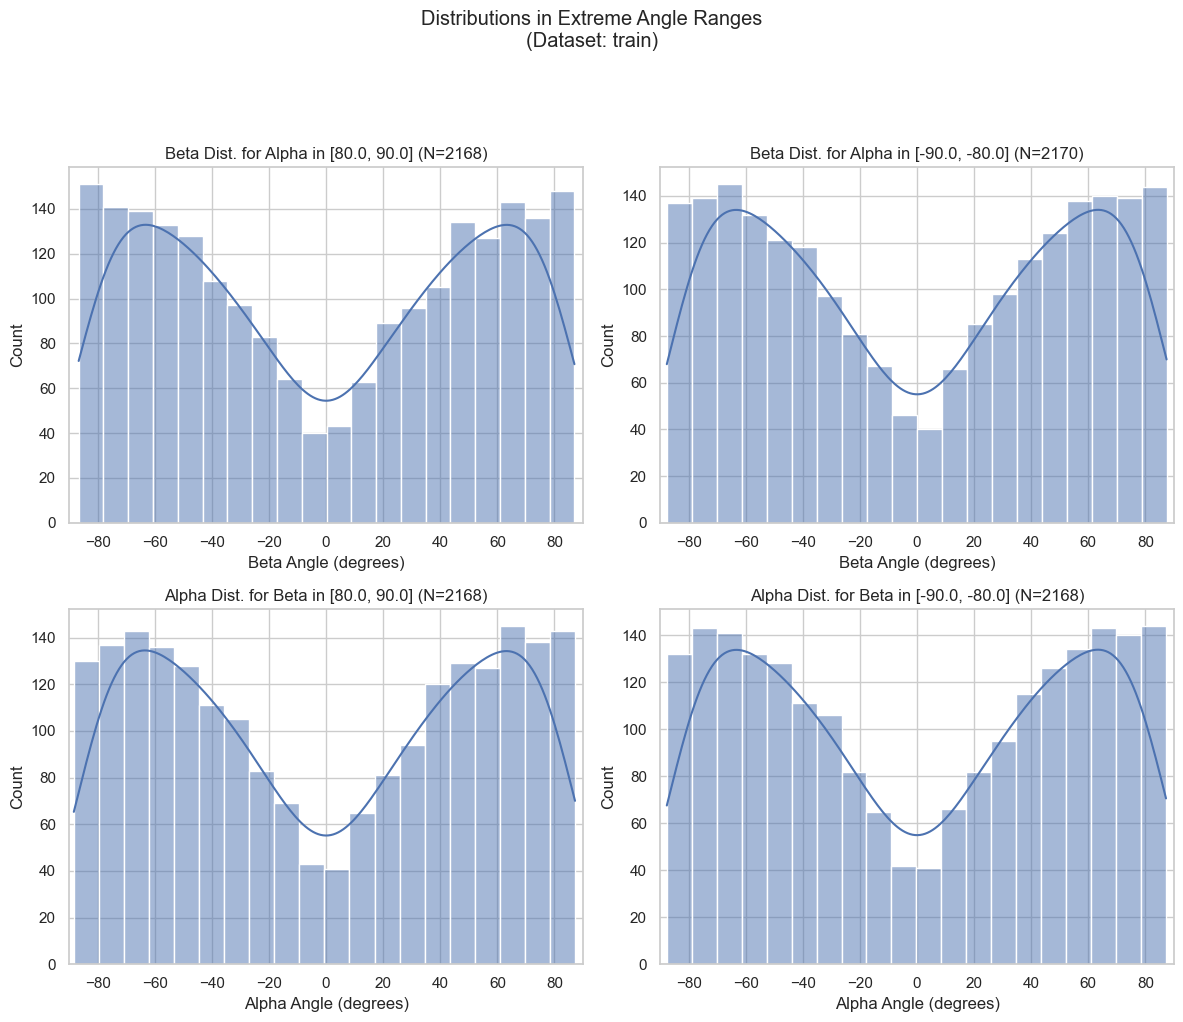

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Assume 'df' is your DataFrame loaded previously with 'alpha' and 'beta' columns
# Assume 'DATASET_DIR' is defined and valid

if not df.empty:
    print(f"\n--- Analyzing Distributions in Extreme Angle Ranges ---")
    if 'alpha' not in df.columns or 'beta' not in df.columns:
        print("Error: 'alpha' or 'beta' columns not found in the DataFrame.")
    else:
        # Ensure data types are float
        try:
            df['alpha'] = df['alpha'].astype(float)
            df['beta'] = df['beta'].astype(float)
        except ValueError as e:
            print(f"Error converting alpha/beta to float: {e}. Check data.")
            # Handle error appropriately


        # --- Define Filter Ranges ---
        high_pos_alpha_min, high_pos_alpha_max = 80.0, 90.0
        high_neg_alpha_min, high_neg_alpha_max = -90.0, -80.0
        high_pos_beta_min, high_pos_beta_max =  80.0, 90.0
        high_neg_beta_min, high_neg_beta_max =  -90.0, -80.0

        # --- Filter Data for each case ---
        df_hp_alpha = df[(df['alpha'] >= high_pos_alpha_min) & (df['alpha'] <= high_pos_alpha_max)]
        df_hn_alpha = df[(df['alpha'] >= high_neg_alpha_min) & (df['alpha'] <= high_neg_alpha_max)]
        df_hp_beta = df[(df['beta'] >= high_pos_beta_min) & (df['beta'] <= high_pos_beta_max)]
        df_hn_beta = df[(df['beta'] >= high_neg_beta_min) & (df['beta'] <= high_neg_beta_max)]

        print(f"Samples with Alpha in [{high_pos_alpha_min}, {high_pos_alpha_max}]: {len(df_hp_alpha)}")
        print(f"Samples with Alpha in [{high_neg_alpha_min}, {high_neg_alpha_max}]: {len(df_hn_alpha)}")
        print(f"Samples with Beta in [{high_pos_beta_min}, {high_pos_beta_max}]: {len(df_hp_beta)}")
        print(f"Samples with Beta in [{high_neg_beta_min}, {high_neg_beta_max}]: {len(df_hn_beta)}")

        # --- Create 2x2 Subplots ---
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle(f'Distributions in Extreme Angle Ranges\n(Dataset: {os.path.basename(DATASET_DIR)})', y=1.02)
        sns.set_theme(style="whitegrid") # Apply a style

        # Common bin settings (optional, adjust as needed)
        # Use a smaller number of bins as we have less data in each subset
        num_bins = 20
        kde = True # Show density curve overlay

        # Determine common x-axis limits for beta plots (-90 to 90 might be reasonable)
        beta_lim = (-90, 90)
        alpha_lim = (-90, 90)

        # 1. Top-Left: Beta distribution for high positive Alpha
        ax = axes[0, 0]
        if not df_hp_alpha.empty:
            sns.histplot(df_hp_alpha, x='beta', ax=ax, bins=num_bins, kde=kde)
            ax.set_title(f'Beta Dist. for Alpha in [{high_pos_alpha_min:.1f}, {high_pos_alpha_max:.1f}] (N={len(df_hp_alpha)})')
            ax.set_xlabel('Beta Angle (degrees)')
            ax.set_xlim(beta_lim)
        else:
            ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(f'Beta Dist. for Alpha in [{high_pos_alpha_min:.1f}, {high_pos_alpha_max:.1f}]')
            ax.set_xlim(beta_lim)


        # 2. Top-Right: Beta distribution for high negative Alpha
        ax = axes[0, 1]
        if not df_hn_alpha.empty:
            sns.histplot(df_hn_alpha, x='beta', ax=ax, bins=num_bins, kde=kde)
            ax.set_title(f'Beta Dist. for Alpha in [{high_neg_alpha_min:.1f}, {high_neg_alpha_max:.1f}] (N={len(df_hn_alpha)})')
            ax.set_xlabel('Beta Angle (degrees)')
            ax.set_xlim(beta_lim)
        else:
            ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(f'Beta Dist. for Alpha in [{high_neg_alpha_min:.1f}, {high_neg_alpha_max:.1f}]')
            ax.set_xlim(beta_lim)


        # 3. Bottom-Left: Alpha distribution for high positive Beta
        ax = axes[1, 0]
        if not df_hp_beta.empty:
            sns.histplot(df_hp_beta, x='alpha', ax=ax, bins=num_bins, kde=kde)
            ax.set_title(f'Alpha Dist. for Beta in [{high_pos_beta_min:.1f}, {high_pos_beta_max:.1f}] (N={len(df_hp_beta)})')
            ax.set_xlabel('Alpha Angle (degrees)')
            ax.set_xlim(alpha_lim)
        else:
            ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(f'Alpha Dist. for Beta in [{high_pos_beta_min:.1f}, {high_pos_beta_max:.1f}]')
            ax.set_xlim(alpha_lim)


        # 4. Bottom-Right: Alpha distribution for high negative Beta
        ax = axes[1, 1]
        if not df_hn_beta.empty:
            sns.histplot(df_hn_beta, x='alpha', ax=ax, bins=num_bins, kde=kde)
            ax.set_title(f'Alpha Dist. for Beta in [{high_neg_beta_min:.1f}, {high_neg_beta_max:.1f}] (N={len(df_hn_beta)})')
            ax.set_xlabel('Alpha Angle (degrees)')
            ax.set_xlim(alpha_lim)
        else:
            ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(f'Alpha Dist. for Beta in [{high_neg_beta_min:.1f}, {high_neg_beta_max:.1f}]')
            ax.set_xlim(alpha_lim)


        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to prevent title overlap
        plt.show()

else:
    print("Skipping Extreme Angle Analysis: Metadata DataFrame is empty.")


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

if not df.empty:
    print(f"\n--- Scatter Plot of Angle Distribution (Alpha on X, Beta on Y) ---")
    if "alpha" not in df.columns or "beta" not in df.columns:
        print("Error: 'alpha' or 'beta' columns not found in the DataFrame.")
    else:
        # Ensure data types are float
        try:
            df["alpha"] = df["alpha"].astype(float)
            df["beta"] = df["beta"].astype(float)
        except ValueError as e:
            print(f"Error converting alpha/beta to float: {e}. Check data.")
            # Handle error appropriately

        max_abs_val = 89

        # --- Create the Scatter Plot (alpha on x, beta on y) ---
        plt.figure(figsize=(12, 10))
        sns.set_theme(style="whitegrid")

        scatter_plot = sns.scatterplot(data=df, x="alpha", y="beta", color="C0", s=5, alpha=0.6, edgecolor="none")

        plt.title(
            f"Plot of Generated (Alpha, Beta) Angles\n(Dataset: {os.path.basename(DATASET_DIR)}, {len(df)} samples)"
        )
        plt.xlabel("Alpha Angle (degrees)")
        plt.ylabel("Beta Angle (degrees)")

        axis_limit = max_abs_val + 2
        plt.xlim(-axis_limit, axis_limit)
        plt.ylim(-axis_limit, axis_limit)

        plt.grid(True, linestyle="--", alpha=0.7)
        plt.gca().set_aspect("equal", adjustable="box")

        plt.tight_layout()
        plt.show()

else:
    print("Skipping Scatter Plot: Metadata DataFrame is empty.")

Skipping Scatter Plot: Metadata DataFrame is empty.



--- Box Plot for Distributions in Extreme Angle Ranges ---
Generating Box plot...


C:\Users\stopc\AppData\Local\Temp\ipykernel_18668\2588150180.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


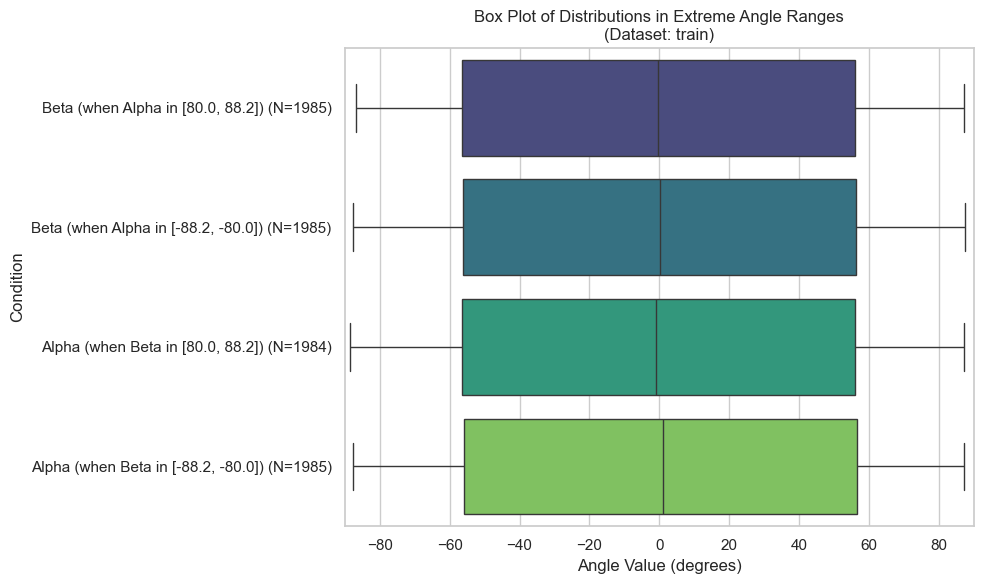

In [80]:
# ## Box Plot for Extreme Angle Distributions
# This plot uses box plots to compare the four conditional distributions 
# (Beta when Alpha is extreme, Alpha when Beta is extreme) side-by-side in a single figure. 
# It highlights median, quartiles, and outliers for each condition.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Assume 'df' is your DataFrame loaded previously with 'alpha' and 'beta' columns
# Assume 'DATASET_DIR' is defined and valid

if not df.empty:
    print(f"\n--- Box Plot for Distributions in Extreme Angle Ranges ---")
    if 'alpha' not in df.columns or 'beta' not in df.columns:
        print("Error: 'alpha' or 'beta' columns not found in the DataFrame.")
    else:
        # Ensure data types are float
        try:
            df['alpha'] = df['alpha'].astype(float)
            df['beta'] = df['beta'].astype(float)
        except ValueError as e:
            print(f"Error converting alpha/beta to float: {e}. Check data.")
            # Handle error appropriately

        # --- Define Filter Ranges ---
        high_pos_alpha_min, high_pos_alpha_max = 80.0, 88.2
        high_neg_alpha_min, high_neg_alpha_max = -88.2, -80.0
        high_pos_beta_min, high_pos_beta_max = 80.0, 88.2
        high_neg_beta_min, high_neg_beta_max = -88.2, -80.0

        # --- Filter Data for each case ---
        # (These lines are reused from the previous example)
        df_hp_alpha = df[(df['alpha'] >= high_pos_alpha_min) & (df['alpha'] <= high_pos_alpha_max)]
        df_hn_alpha = df[(df['alpha'] >= high_neg_alpha_min) & (df['alpha'] <= high_neg_alpha_max)]
        df_hp_beta = df[(df['beta'] >= high_pos_beta_min) & (df['beta'] <= high_pos_beta_max)]
        df_hn_beta = df[(df['beta'] >= high_neg_beta_min) & (df['beta'] <= high_neg_beta_max)]

        # --- Prepare Data for Box Plot (same structure as for Ridgeline) ---
        combined_data = []
        # Condition 1: Beta distribution for high positive Alpha
        if not df_hp_alpha.empty:
            temp_df = pd.DataFrame({'value': df_hp_alpha['beta']})
            temp_df['condition'] = f'Beta (when Alpha in [{high_pos_alpha_min:.1f}, {high_pos_alpha_max:.1f}]) (N={len(df_hp_alpha)})' # Add N to label
            combined_data.append(temp_df)

        # Condition 2: Beta distribution for high negative Alpha
        if not df_hn_alpha.empty:
            temp_df = pd.DataFrame({'value': df_hn_alpha['beta']})
            temp_df['condition'] = f'Beta (when Alpha in [{high_neg_alpha_min:.1f}, {high_neg_alpha_max:.1f}]) (N={len(df_hn_alpha)})'
            combined_data.append(temp_df)

        # Condition 3: Alpha distribution for high positive Beta
        if not df_hp_beta.empty:
            temp_df = pd.DataFrame({'value': df_hp_beta['alpha']})
            temp_df['condition'] = f'Alpha (when Beta in [{high_pos_beta_min:.1f}, {high_pos_beta_max:.1f}]) (N={len(df_hp_beta)})'
            combined_data.append(temp_df)

        # Condition 4: Alpha distribution for high negative Beta
        if not df_hn_beta.empty:
            temp_df = pd.DataFrame({'value': df_hn_beta['alpha']})
            temp_df['condition'] = f'Alpha (when Beta in [{high_neg_beta_min:.1f}, {high_neg_beta_max:.1f}]) (N={len(df_hn_beta)})'
            combined_data.append(temp_df)

        # Combine into a single DataFrame if any data exists
        if combined_data:
            boxplot_df = pd.concat(combined_data, ignore_index=True)

            # --- Create the Box Plot ---
            print("Generating Box plot...")
            plt.figure(figsize=(10, 6)) # Adjust figure size as needed
            sns.set_theme(style="whitegrid")

            # Order of categories on y-axis (optional, default is alphabetical/order of appearance)
            # You can define a specific order if desired:
            condition_order = [
                 f'Beta (when Alpha in [{high_pos_alpha_min:.1f}, {high_pos_alpha_max:.1f}]) (N={len(df_hp_alpha)})',
                 f'Beta (when Alpha in [{high_neg_alpha_min:.1f}, {high_neg_alpha_max:.1f}]) (N={len(df_hn_alpha)})',
                 f'Alpha (when Beta in [{high_pos_beta_min:.1f}, {high_pos_beta_max:.1f}]) (N={len(df_hp_beta)})',
                 f'Alpha (when Beta in [{high_neg_beta_min:.1f}, {high_neg_beta_max:.1f}]) (N={len(df_hn_beta)})'
            ]
            # Filter order to only include conditions with data
            condition_order = [c for c in condition_order if c in boxplot_df['condition'].unique()]


            ax = sns.boxplot(
                data=boxplot_df,
                x='value',      # Angle values on the horizontal axis
                y='condition',  # Conditions map to the vertical axis
                order=condition_order, # Control the order of boxes
                palette="viridis", # Color palette
                orient='h',     # Horizontal orientation (y=category, x=value)
                showfliers=True, # Show outliers (points beyond whiskers)
                fliersize=3     # Adjust outlier marker size
            )

            # --- Set Labels and Title ---
            ax.set_xlabel("Angle Value (degrees)")
            ax.set_ylabel("Condition") # Y-axis label is the condition
            ax.set_title(f'Box Plot of Distributions in Extreme Angle Ranges\n(Dataset: {os.path.basename(DATASET_DIR)})')

            # Optional: Set x-axis limits if needed for consistency
            ax.set_xlim(-90, 90) # Example limits, adjust if necessary

            plt.tight_layout() # Adjust layout
            plt.show()

        else:
            print("No data found in any of the extreme angle ranges to plot.")

else:
    print("Skipping Box Plot: Metadata DataFrame is empty.")




--- Q-Q Plots for Distributions in Extreme Angle Ranges ---

Generating Q-Q Plots (Sample vs. Normal)...


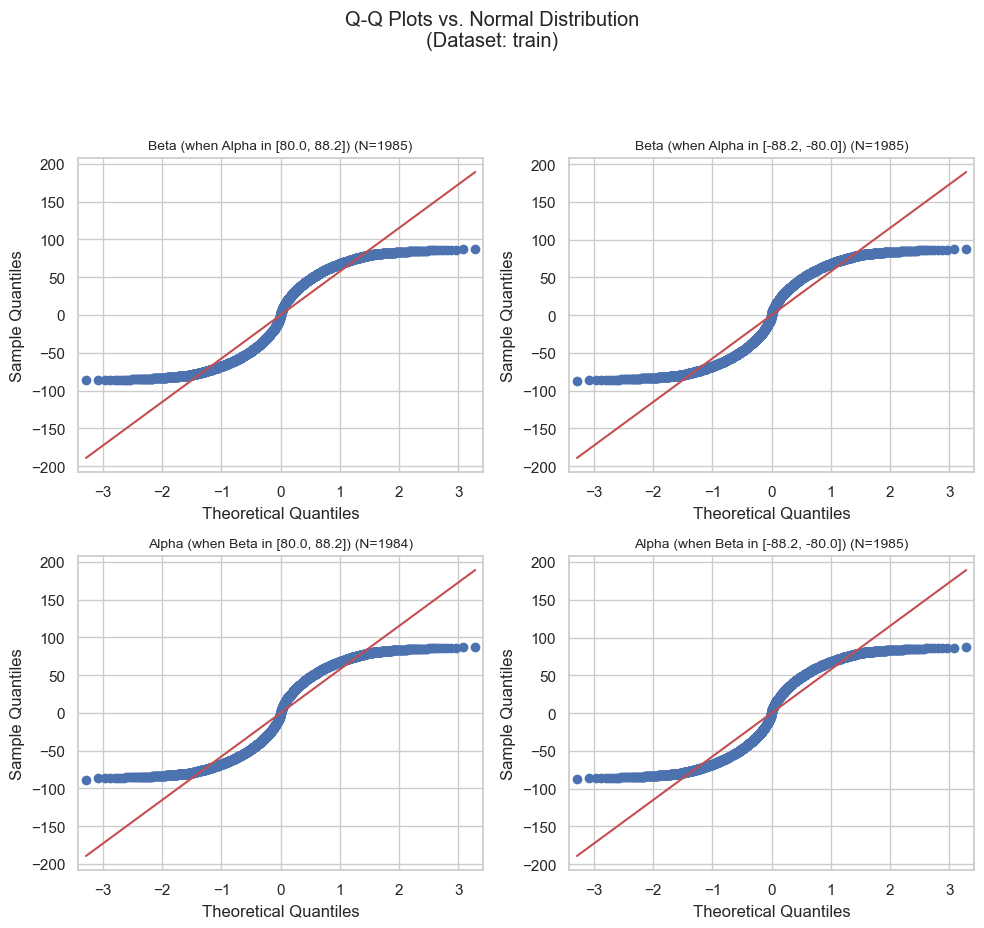


Generating Q-Q Plot (Sample vs. Sample - Beta comparison)...


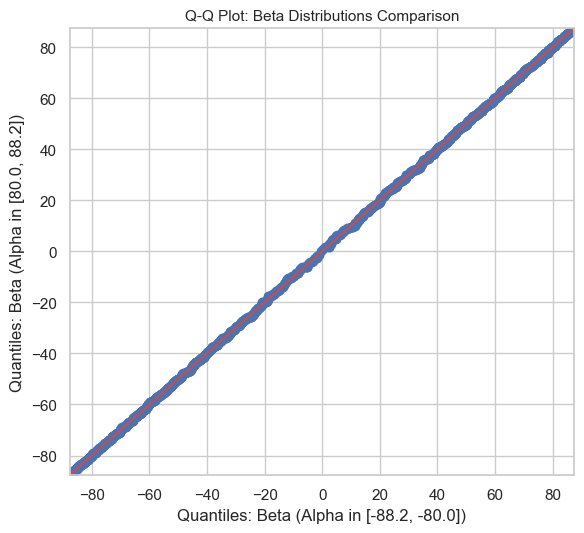

In [81]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Using seaborn style enhances plots
import statsmodels.api as sm # For Q-Q plots
import os

# Assume 'df' is your DataFrame loaded previously with 'alpha' and 'beta' columns
# Assume 'DATASET_DIR' is defined and valid

# quantile-quantile (Q-Q) plots are useful for comparing the distribution of a sample to 
# a theoretical distribution (e.g., normal distribution).
# They can also be used to compare two samples against each other.

if not df.empty:
    print(f"\n--- Q-Q Plots for Distributions in Extreme Angle Ranges ---")
    if 'alpha' not in df.columns or 'beta' not in df.columns:
        print("Error: 'alpha' or 'beta' columns not found in the DataFrame.")
    else:
        # Ensure data types are float
        try:
            df['alpha'] = df['alpha'].astype(float)
            df['beta'] = df['beta'].astype(float)
        except ValueError as e:
            print(f"Error converting alpha/beta to float: {e}. Check data.")
            # Handle error appropriately

        # --- Define Filter Ranges ---
        high_pos_alpha_min, high_pos_alpha_max = 80.0, 88.2
        high_neg_alpha_min, high_neg_alpha_max = -88.2, -80.0
        high_pos_beta_min, high_pos_beta_max = 80.0, 88.2
        high_neg_beta_min, high_neg_beta_max = -88.2, -80.0

        # --- Filter Data for each case ---
        # (Reusing filters from previous examples)
        df_hp_alpha = df[(df['alpha'] >= high_pos_alpha_min) & (df['alpha'] <= high_pos_alpha_max)]
        df_hn_alpha = df[(df['alpha'] >= high_neg_alpha_min) & (df['alpha'] <= high_neg_alpha_max)]
        df_hp_beta = df[(df['beta'] >= high_pos_beta_min) & (df['beta'] <= high_pos_beta_max)]
        df_hn_beta = df[(df['beta'] >= high_neg_beta_min) & (df['beta'] <= high_neg_beta_max)]

        # --- Plot 1: Sample vs. Normal Q-Q Plots (2x2 Grid) ---
        print("\nGenerating Q-Q Plots (Sample vs. Normal)...")
        fig1, axes = plt.subplots(2, 2, figsize=(10, 9))
        fig1.suptitle(f'Q-Q Plots vs. Normal Distribution\n(Dataset: {os.path.basename(DATASET_DIR)})', y=1.03)
        sns.set_theme(style="whitegrid")

        plot_configs = [
            (axes[0, 0], df_hp_alpha['beta'], f'Beta (when Alpha in [{high_pos_alpha_min:.1f}, {high_pos_alpha_max:.1f}])'),
            (axes[0, 1], df_hn_alpha['beta'], f'Beta (when Alpha in [{high_neg_alpha_min:.1f}, {high_neg_alpha_max:.1f}])'),
            (axes[1, 0], df_hp_beta['alpha'], f'Alpha (when Beta in [{high_pos_beta_min:.1f}, {high_pos_beta_max:.1f}])'),
            (axes[1, 1], df_hn_beta['alpha'], f'Alpha (when Beta in [{high_neg_beta_min:.1f}, {high_neg_beta_max:.1f}])')
        ]

        for ax, data_series, title in plot_configs:
            if not data_series.empty:
                sm.qqplot(data_series, line='s', ax=ax) # 's' line assumes mean/std from sample
                ax.set_title(f'{title} (N={len(data_series)})', fontsize=10)
                # Customize axis labels if needed (default is usually okay)
                # ax.set_xlabel("Theoretical Quantiles (Normal)")
                # ax.set_ylabel("Sample Quantiles")
            else:
                ax.text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                ax.set_title(title + ' (N=0)', fontsize=10)
                ax.set_xlabel("")
                ax.set_ylabel("")


        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()


        # --- Plot 2: Sample vs. Sample Q-Q Plot (Example) ---
        print("\nGenerating Q-Q Plot (Sample vs. Sample - Beta comparison)...")

        # Check if we have data for both conditions we want to compare
        if not df_hp_alpha.empty and not df_hn_alpha.empty:
            fig2, ax2 = plt.subplots(figsize=(6, 5.5))
            sns.set_theme(style="whitegrid")

            # Compare Beta distribution for high positive Alpha vs. high negative Alpha
            data1 = df_hp_alpha['beta']
            data2 = df_hn_alpha['beta']

            sm.qqplot_2samples(data1, data2, line='45', ax=ax2) # '45' adds y=x line

            ax2.set_title('Q-Q Plot: Beta Distributions Comparison', fontsize=11)
            ax2.set_xlabel(f'Quantiles: Beta (Alpha in [{high_neg_alpha_min:.1f}, {high_neg_alpha_max:.1f}])')
            ax2.set_ylabel(f'Quantiles: Beta (Alpha in [{high_pos_alpha_min:.1f}, {high_pos_alpha_max:.1f}])')
            # Ensure axes cover roughly the same range if possible
            min_val = min(data1.min(), data2.min())
            max_val = max(data1.max(), data2.max())
            ax2.set_xlim(min_val, max_val)
            ax2.set_ylim(min_val, max_val)

            plt.tight_layout()
            plt.show()

        else:
            print("Skipping Sample vs. Sample plot: Not enough data in one or both comparison groups.")
            if df_hp_alpha.empty: print(f"(Missing data for Alpha in [{high_pos_alpha_min:.1f}, {high_pos_alpha_max:.1f}])")
            if df_hn_alpha.empty: print(f"(Missing data for Alpha in [{high_neg_alpha_min:.1f}, {high_neg_alpha_max:.1f}])")


else:
    print("Skipping Q-Q Plots: Metadata DataFrame is empty.")